# <span style="color:purple">TAQ Project in R</span>

In this project, we'll use the __NYSE Trade and Quote (TAQ)__ database on WRDS described here: https://wrds-www.wharton.upenn.edu/pages/about/data-vendors/nyse-trade-and-quote-taq/.  This is our workflow:

1. Select a company and a trading date. Fetch stock price data for this company by the second.
2. Obtain the five-minute average stock price for each observation (not a rolling average) as a new table.
3. Merge the two tables.
4. Graph the time series for the stock prices with the five-minute average indicated by blue dots.

To get started, we'll first load our R libraries and then establish a WRDS connection.

In [2]:
# Load necessary libraries
library(DBI)
library(RPostgres)
#library(dplyr)
library(lubridate)
library(ggplot2)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [4]:
# Connect to WRDS
con <- dbConnect(Postgres(),
                  host='wrds-pgdata.wharton.upenn.edu',
                  port=9737,
                  dbname='wrds',
                  sslmode='require',
                  user='best-user-ever')

### <span style="color:purple">1. Obtain WRDS data table</span>

Select a company and date to use in this example. 

In [5]:
# Define date and stock
dd <- '20230622'
stock <- "AAPL"

Submit a sql query.

In [6]:
# Create SQL query
sql <- paste0("
  SELECT CONCAT(date, ' ', time_m) AS DT,
         ex, sym_root, sym_suffix, price, size, tr_scond
  FROM taqmsec.ctm_", dd, "
  WHERE (ex = 'N' OR ex = 'T' OR ex = 'Q' OR ex = 'A')
    AND sym_root = '", stock, "'
    AND price != 0 AND tr_corr = '00'
")

# Execute the query
df_aapl <- dbGetQuery(con, sql)

# print the column names
print(colnames(df_aapl))

# print the number of columns and rows
print(dim(df_aapl))

[1] "dt"         "ex"         "sym_root"   "sym_suffix" "price"     
[6] "size"       "tr_scond"  
[1] 111590      7


### <span style="color:purple">2. Obtain 5-minute averages</span>


In [7]:
# Convert 'DT' to datetime and round to nearest 5 minutes
df_aapl$dt <- round_date(as.POSIXct(df_aapl$dt, format = "%Y-%m-%d %H:%M:%OS"), "5 minutes")

# Obtain 5 minute average price
df_aapl_resampled <- aggregate(price ~ dt, df_aapl, function(x) mean(x, na.rm = TRUE))
colnames(df_aapl_resampled)[2] <- "avg_price"


### <span style="color:purple">3. Merge Tables</span>

In [8]:
# Merge the two data frames
df_aapl$avg_price <- NULL
df_aapl <- merge(df_aapl, df_aapl_resampled, by = "dt", all.x = TRUE)

# Fill NA values in 'avg_price'
na_locs <- which(is.na(df_aapl$avg_price))
df_aapl$avg_price[na_locs] <- df_aapl$avg_price[na_locs - 1]

# print the column names
print(colnames(df_aapl))

# print the number of columns and rows
print(dim(df_aapl))

[1] "dt"         "ex"         "sym_root"   "sym_suffix" "price"     
[6] "size"       "tr_scond"   "avg_price" 
[1] 111590      8


### <span style="color:purple">4. Graph Results</span>

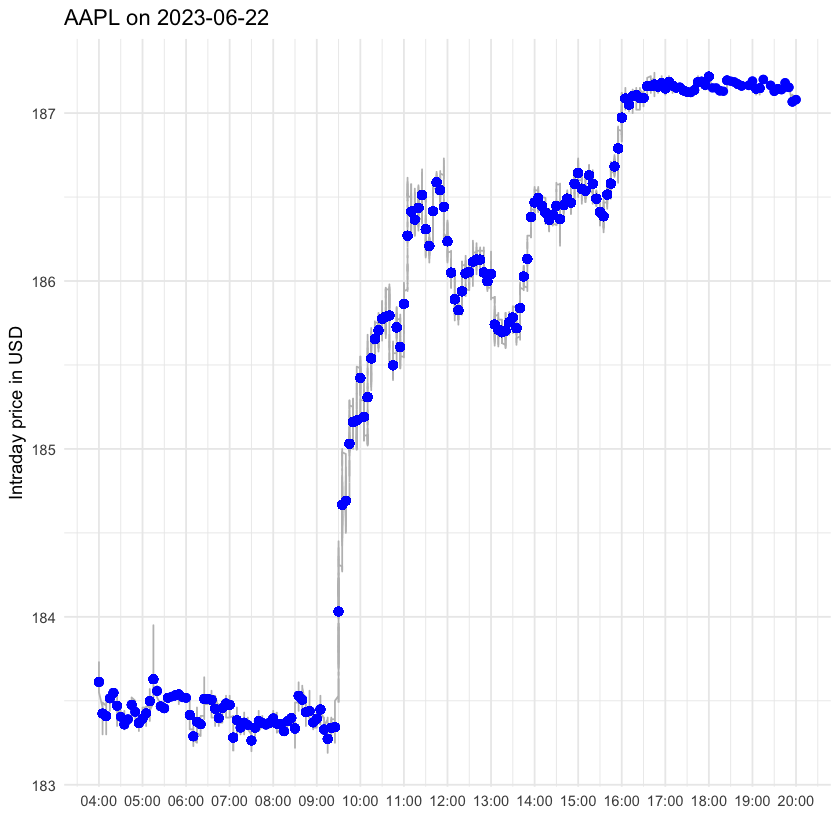

In [9]:
# Plot the price series
ggplot(df_aapl, aes(x = dt)) +
  geom_line(aes(y = price), color = "gray") +
  geom_point(aes(y = avg_price), color = "blue", size = 2) +
  scale_y_continuous("Intraday price in USD", limits = c(min(df_aapl$price), max(df_aapl$price))) +
  scale_x_datetime("", date_labels = "%H:%M", date_breaks = "60 min") +
  ggtitle(paste0("AAPL on ", unique(as.Date(df_aapl$dt)))) +
  theme_minimal()


### <span style="color:purple">Lab 3</span>
:::{admonition} Lab 3 - Expand Sample Project

Either in R or Python: 

1. Grab data from another TAQ table or variable from the same table. Save changes to git.
2. Add a test.
   - Example: test whether the SQL query returns an empty dataframe and skip to the next entry.
3. Add more companies and dates to obtain data from.

```{dropdown} Lab 3 Answer Key
:::{admonition} 

[Python Code](../code/lab3/answer_key/taq_project.py)

[R Code](../code/lab3/answer_key/taq_project.R)
:::